# Frequency correlation plots for simulated populations with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, probplot
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
data_root = "../results/builds/simulated/simulated_sample_3"
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_tree"
first_validation_timepoint = "2023-10-01"

min_clade_frequency = 0.15
precision = 4
pseudofrequency = 0.001

In [3]:
sns.set_style("white")
plt.style.use("huddlej")

In [4]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18
mpl.rcParams['text.usetex'] = False

In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [7]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [8]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [9]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [10]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [11]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [12]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [13]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [14]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [15]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

Merge clade frequencies between adjacent years.

In [16]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

Select clades with an initial frequency >15%.

In [17]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [18]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [19]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [20]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [21]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [22]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [23]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [24]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [25]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [26]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [27]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.8673469387755102

In [28]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.5806451612903226

In [29]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [30]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())
log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

In [31]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [32]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [33]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [34]:
confusion_matrix

{'tp': 85, 'tn': 18, 'fp': 13, 'fn': 13}

In [35]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

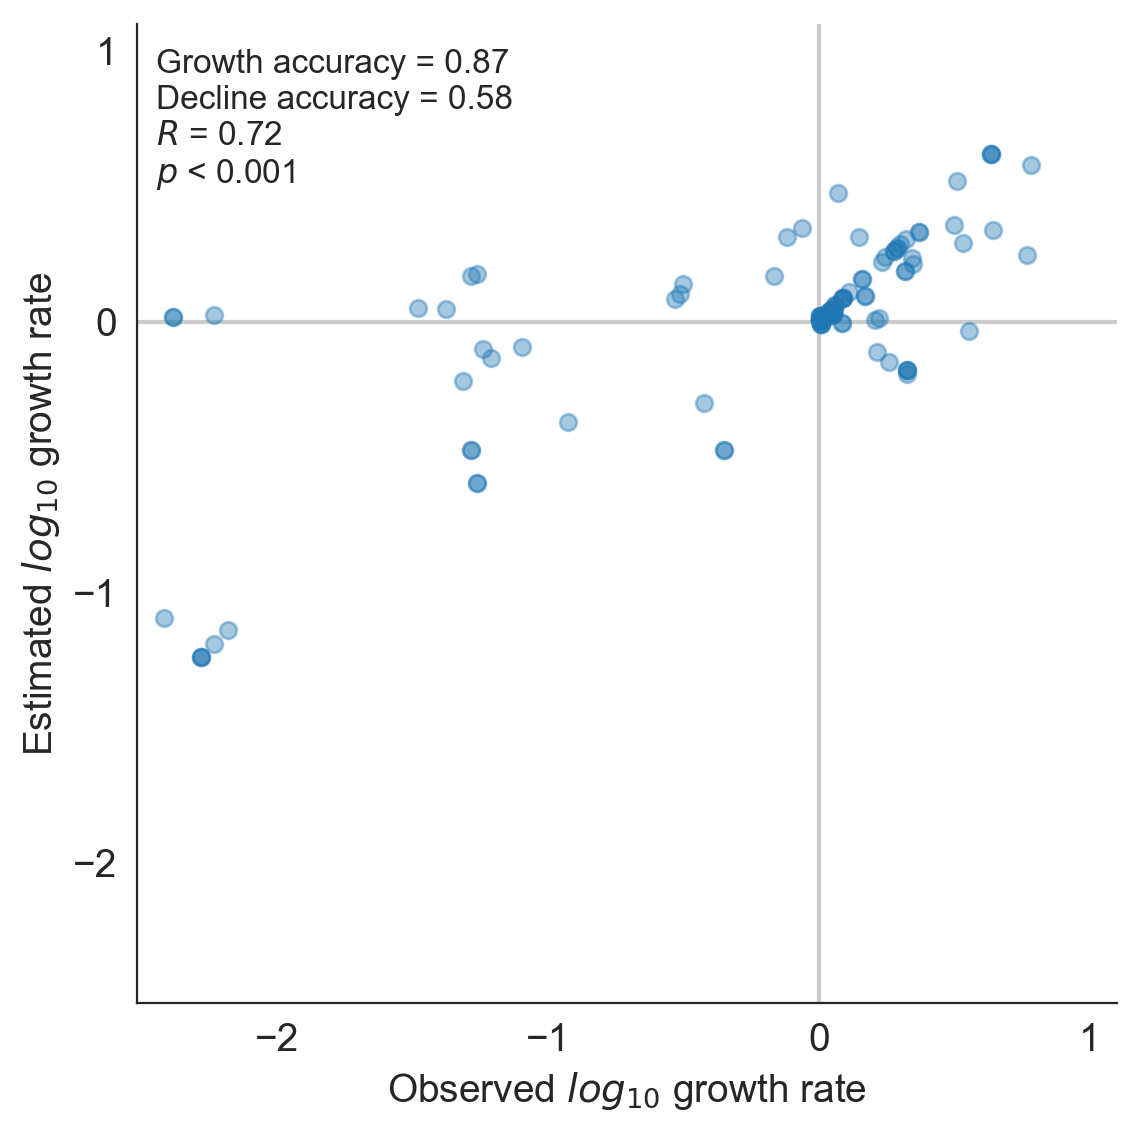

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations-by-clade-growth.png")

In [37]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [38]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
78,2033-10-01,8d6504d,0.16,0.05,0.22,0.312500,1.375000,2033,-0.499256,0.137566,False,True,False
272,2037-10-01,8f812d8,0.17,0.13,0.35,0.764706,2.058824,2037,-0.115725,0.312311,False,True,False
362,2039-04-01,4e6e637,0.17,0.00,0.18,0.000000,1.058824,2039,-2.232996,0.024682,False,True,False
121,2034-10-01,d48329b,0.19,0.13,0.28,0.684211,1.473684,2034,-0.163762,0.167673,False,True,False
244,2037-04-01,a2f1320,0.20,0.01,0.30,0.050000,1.500000,2037,-1.261803,0.175370,False,True,False
215,2036-10-01,a125a94,0.21,0.01,0.31,0.047619,1.476190,2036,-1.282890,0.168478,False,True,False
32,2032-04-01,9c89bcc,0.23,0.20,0.51,0.869565,2.217391,2032,-0.060416,0.344809,False,True,False
39,2032-10-01,16b37cd,0.23,0.07,0.29,0.304348,1.260870,2032,-0.512354,0.100281,False,True,False
43,2032-10-01,5c73ba7,0.24,0.00,0.25,0.000000,1.041667,2032,-2.382017,0.017657,False,True,False
46,2032-10-01,9c89bcc,0.24,0.07,0.29,0.291667,1.208333,2032,-0.530759,0.081876,False,True,False


## Inspect uncertainty in forecast accuracy

Use observed forecasting errors to inspect the accuracy of one-year lookaheads based on the initial frequency of each clade.

In [39]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
0,2031-04-01,03167e3,0.16,0.98,0.61,6.125000,3.812500,2031,0.784843,0.579215,True,True,True
1,2031-04-01,1238505,0.47,0.98,0.72,2.085106,1.531915,2031,0.318648,0.184914,True,True,True
2,2031-04-01,236447c,0.93,1.00,0.98,1.075269,1.053763,2031,0.031484,0.022719,True,True,True
3,2031-04-01,30dddad,0.44,0.98,0.72,2.227273,1.636364,2031,0.347230,0.213497,True,True,True
4,2031-04-01,695af4b,0.26,0.02,0.21,0.076923,0.807692,2031,-1.094421,-0.092358,False,False,True


In [40]:
complete_clade_frequencies["clade_error"] = complete_clade_frequencies["frequency_final"] - complete_clade_frequencies["projected_frequency"]

In [41]:
complete_clade_frequencies["absolute_clade_error"] = np.abs(complete_clade_frequencies["clade_error"])

In [42]:
number_of_bootstrap_samples = 100
bootstrap_samples = []
for i in range(number_of_bootstrap_samples):
    complete_clade_frequencies_sample = complete_clade_frequencies.sample(frac=1.0, replace=True).copy()
    z = sm.nonparametric.lowess(
        complete_clade_frequencies_sample["absolute_clade_error"].values * 100,
        complete_clade_frequencies_sample["frequency"].values * 100
    )
    exogenous_frequency = z[:, 0]
    bootstrap_samples.append(z[:, 1])

In [43]:
bootstrap_samples = np.array(bootstrap_samples)

In [44]:
# Calculate the mean and 95% CIs from bootstraps.
mean_lowess_fit = np.mean(bootstrap_samples, axis=0)
upper_lowess_fit = np.percentile(bootstrap_samples, 97.5, axis=0)
lower_lowess_fit = np.percentile(bootstrap_samples, 2.5, axis=0)

(-3.9290845206159615, 100)

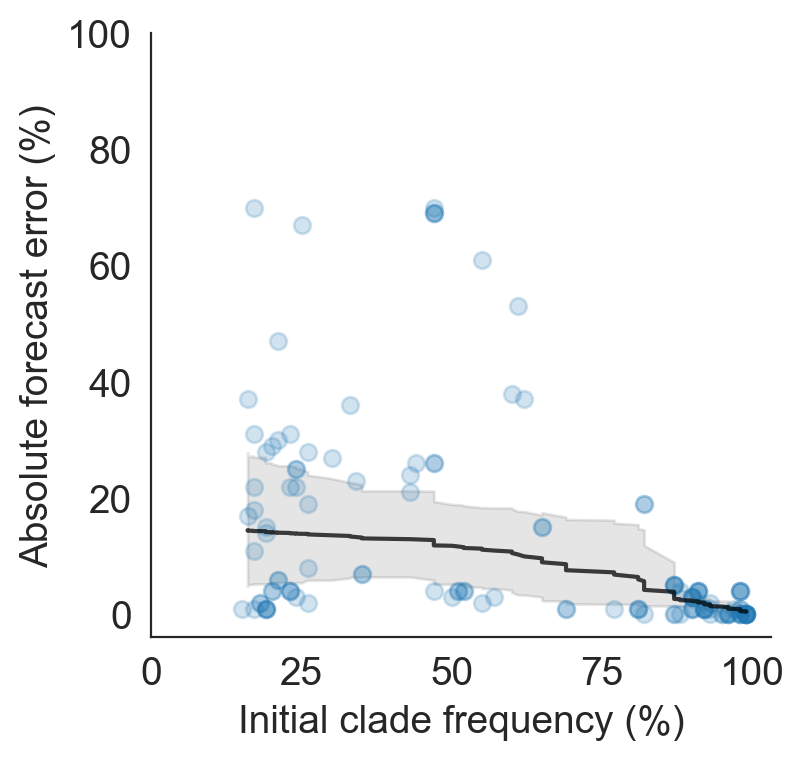

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["absolute_clade_error"].values * 100,
    "o",
    alpha=0.2
)

ax.fill_between(
    exogenous_frequency,
    lower_lowess_fit,
    upper_lowess_fit,
    alpha=0.1,
    color="black"
)
ax.plot(
    exogenous_frequency,
    mean_lowess_fit,
    alpha=0.75,
    color="black"
)

ax.set_xlabel("Initial clade frequency (%)")
ax.set_ylabel("Absolute forecast error (%)")

ax.set_xlim(left=0)
ax.set_ylim(top=100)

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [46]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [47]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [48]:
sorted_df["timepoint_estimated_rank"] = sorted_df.groupby("timepoint")["y"].rank(pct=True)

In [49]:
rank_rho, rank_p = spearmanr(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"]
)

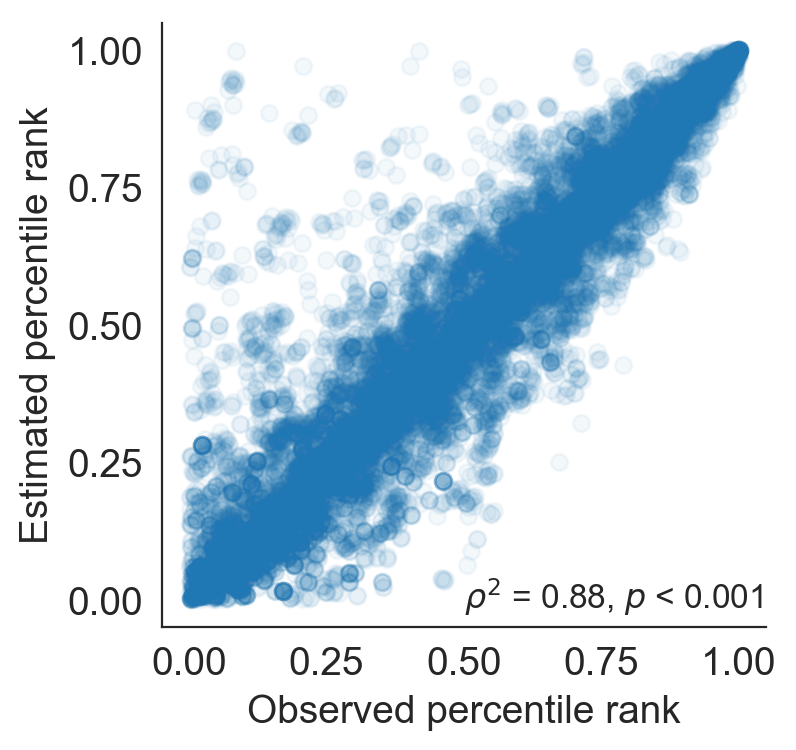

In [50]:
if rank_p < 0.001:
    rank_p_value = "$p$ < 0.001"
else:
    rank_p_value = "$p$ = %.3f" % rank_p

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"],
    "o",
    alpha=0.05
)

ax.text(
    0.5,
    0.05,
    "$\\rho^2$ = %.2f, %s" % (rank_rho ** 2, rank_p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ticks = np.arange(0, 1.01, 0.25)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlabel("Observed percentile rank")
ax.set_ylabel("Estimated percentile rank")
ax.set_aspect("equal")

In [51]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint")["timepoint_rank"].first().reset_index()

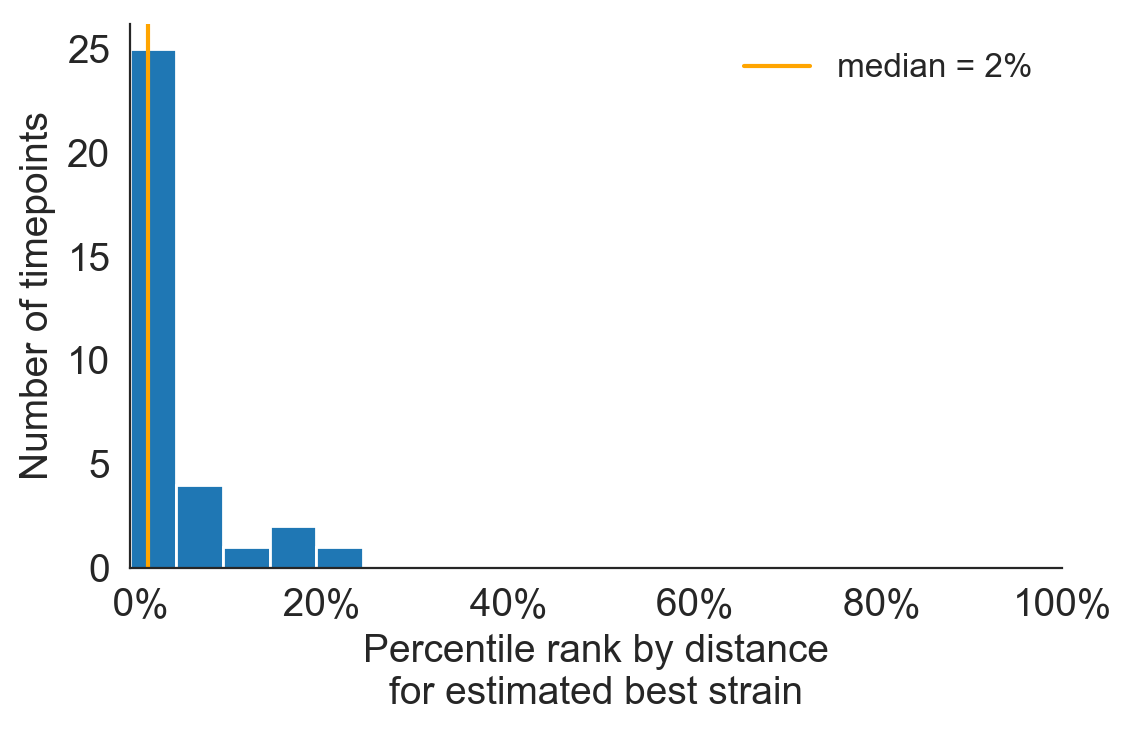

In [52]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
ax.set_ylabel("Number of timepoints")

plt.tight_layout()
plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations-by-best-strain.png")

## Merge validation figures into subpanels of one figure

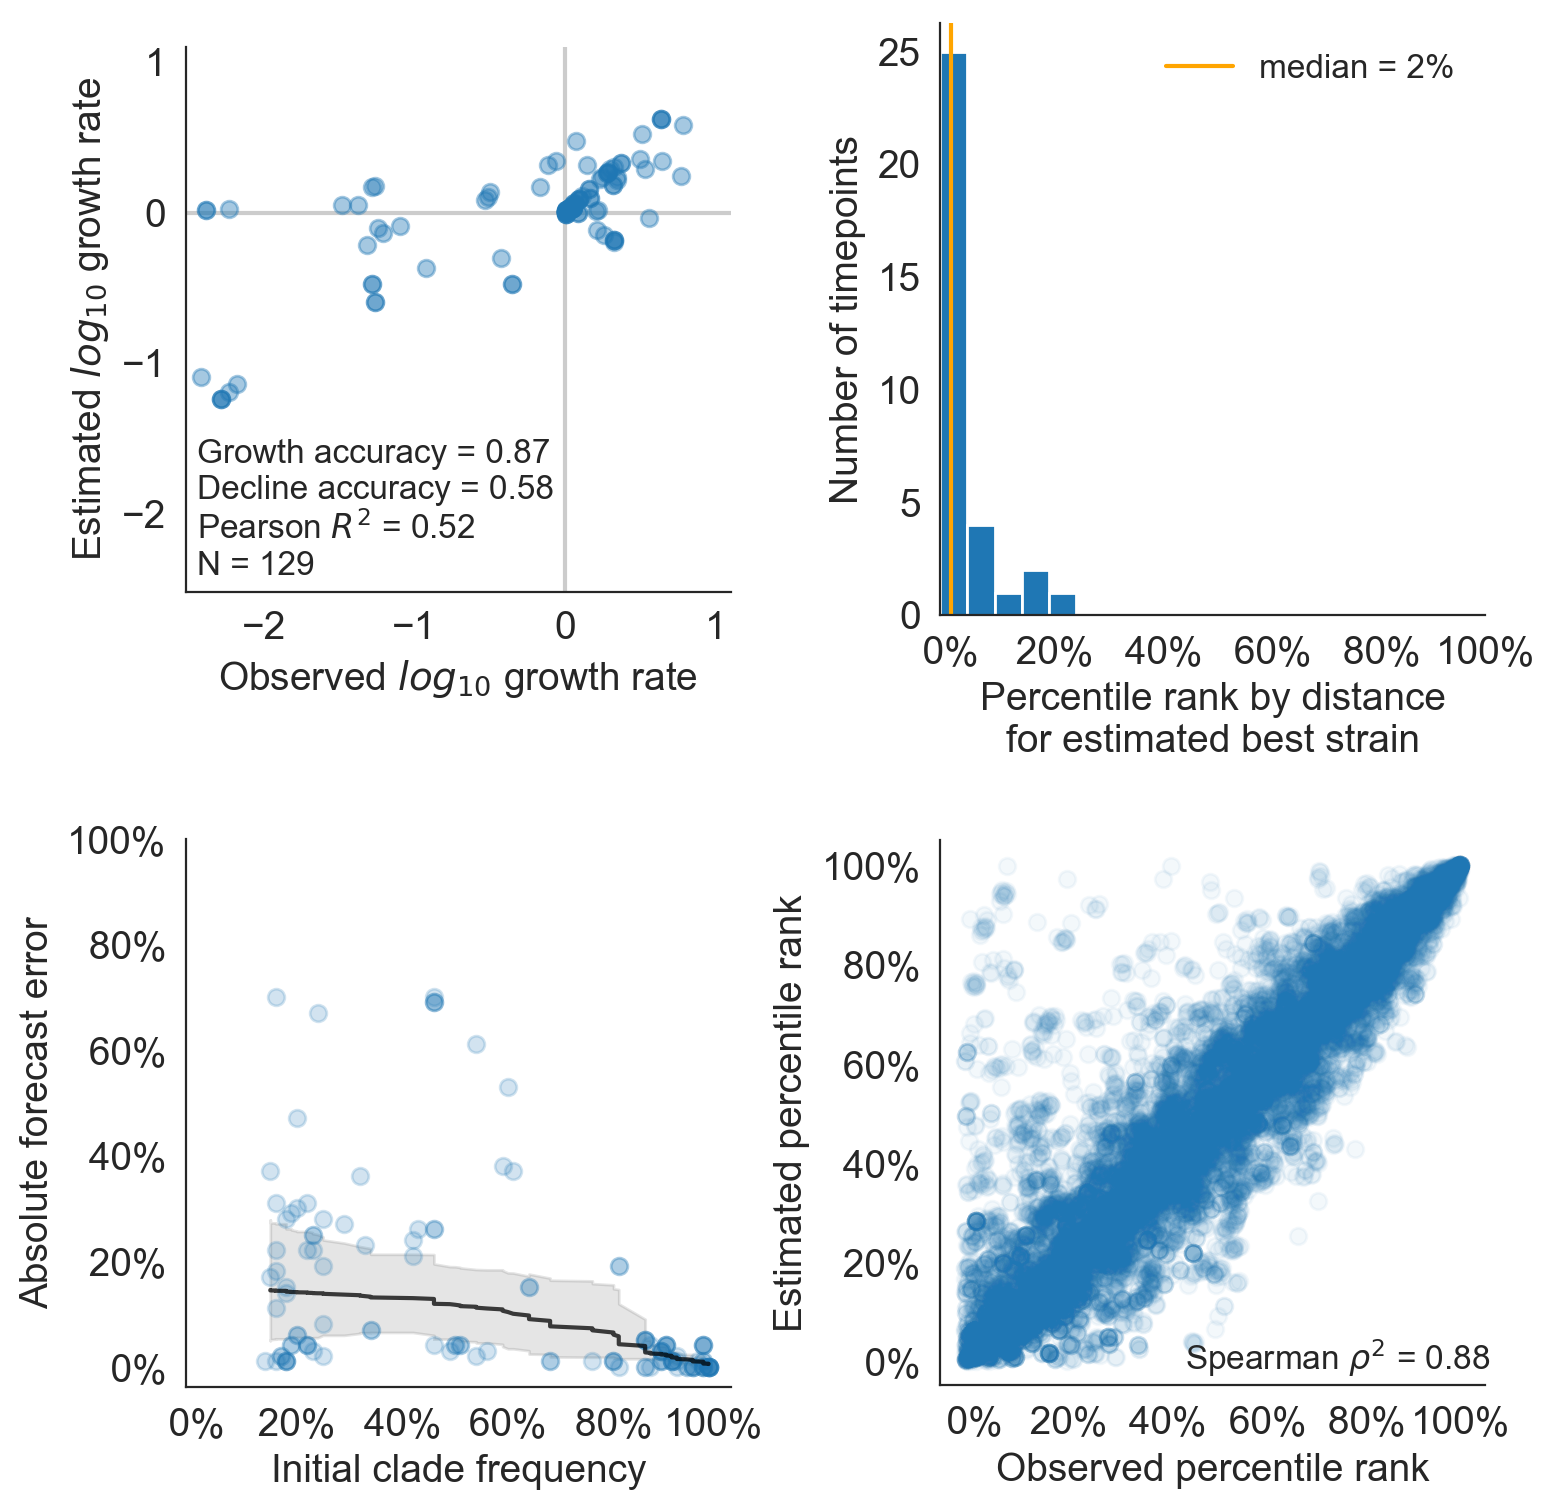

In [53]:
fig = plt.figure(figsize=(8, 8), facecolor='w')
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1)

ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p value$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.15,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\nPearson $R^2$ = %.2f\nN = %s" % (
        growth_accuracy,
        decline_accuracy,
        r ** 2,
        complete_clade_frequencies.shape[0]
    ),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

growth_rate_ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(growth_rate_ticks)
clade_ax.set_yticks(growth_rate_ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticks(ticks)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in ticks])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

#
# Absolute clade forecast errors with uncertainty.
#
forecast_error_ax = fig.add_subplot(gs[2])
forecast_error_ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["absolute_clade_error"].values * 100,
    "o",
    alpha=0.2
)

forecast_error_ax.fill_between(
    exogenous_frequency,
    lower_lowess_fit,
    upper_lowess_fit,
    alpha=0.1,
    color="black"
)
forecast_error_ax.plot(
    exogenous_frequency,
    mean_lowess_fit,
    alpha=0.75,
    color="black"
)

forecast_error_ax.set_xlabel("Initial clade frequency")
forecast_error_ax.set_ylabel("Absolute forecast error")

forecast_error_ax.set_xticks(ticks * 100)
forecast_error_ax.set_yticks(ticks * 100)
forecast_error_ax.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])
forecast_error_ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])

forecast_error_ax.set_aspect("equal")

#
# Observed vs. estimated percentile rank for all strains at all timepoints.
#

all_rank_ax = fig.add_subplot(gs[3])

if rank_p < 0.001:
    rank_p_value = "$p$ < 0.001"
else:
    rank_p_value = "$p$ = %.3f" % rank_p

all_rank_ax.plot(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"],
    "o",
    alpha=0.05
)

all_rank_ax.text(
    0.45,
    0.05,
    "Spearman $\\rho^2$ = %.2f" % (rank_rho ** 2,),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=all_rank_ax.transAxes
)

all_rank_ax.set_xticks(ticks)
all_rank_ax.set_yticks(ticks)
all_rank_ax.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])
all_rank_ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])

all_rank_ax.set_xlabel("Observed percentile rank")
all_rank_ax.set_ylabel("Estimated percentile rank")
all_rank_ax.set_aspect("equal")

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")

In [54]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

32

In [55]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [56]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.9696969696969697